In [8]:
pip install scikit-learn==1.1.3 -q

Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip install phik -q

In [10]:
!pip install shap -q

**Заказчик исследования**: Интернет-магазин «В один клик»

**Задача**:

1.	Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2.	В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3.	Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.
    
**Цель**: повышение активности пользователей интернет-магазина
    
**Краткий план действий**:

1. загрузка данных и их описание
2. предобработка данных
3. исследовательский анализ данных: статистический анализ, удаление выбросов
4. Корреляционный анализ: анализ связи целевого признака с входными признаками, мультиколлинеарность
5. поиск лучшей модели
6. сегментация покупателей
6. итоговые выводы и рекомендации

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import phik
import shap
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    roc_auc_score,
    f1_score
)

### Загрузка данных

#### сохранение данных в датафреймы

In [2]:
market_file = pd.read_csv('/datasets/market_file.csv', sep = ',')
market_money = pd.read_csv('/datasets/market_money.csv', sep = ',')
market_time = pd.read_csv('/datasets/market_time.csv', sep = ',')
money = pd.read_csv('/datasets/money.csv', sep = ';', decimal= ',')

NameError: name 'pd' is not defined

#### общая информация о каждом датафрейме и изменение наименования столбцов

In [13]:
display(market_file.head())
market_file.info()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 1300 entries, 0 to 1299

Data columns (total 13 columns):

 #   Column                               Non-Null Count  Dtype  

---  ------                               --------------  -----  

 0   id                                   1300 non-null   int64  

 1   Покупательская активность            1300 non-null   object 

 2   Тип сервиса                          1300 non-null   object 

 3   Разрешить сообщать                   1300 non-null   object 

 4   Маркет_актив_6_мес                   1300 non-null   float64

 5   Маркет_актив_тек_мес                 1300 non-null   int64  

 6   Длительность                         1300 non-null   int64  

 7   Акционные_покупки                    1300 non-null   float64

 8   Популярная_категория                 1300 non-null   object 

 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  

 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  

 11  Ошибка_сервиса

In [14]:
display(market_money.head())
market_money.info()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3900 entries, 0 to 3899

Data columns (total 3 columns):

 #   Column   Non-Null Count  Dtype  

---  ------   --------------  -----  

 0   id       3900 non-null   int64  

 1   Период   3900 non-null   object 

 2   Выручка  3900 non-null   float64

dtypes: float64(1), int64(1), object(1)

memory usage: 91.5+ KB


In [15]:
display(market_time.head())
market_time.info()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 2600 entries, 0 to 2599

Data columns (total 3 columns):

 #   Column  Non-Null Count  Dtype 

---  ------  --------------  ----- 

 0   id      2600 non-null   int64 

 1   Период  2600 non-null   object

 2   минут   2600 non-null   int64 

dtypes: int64(2), object(1)

memory usage: 61.1+ KB


In [16]:
display(money.head())
money.info()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 1300 entries, 0 to 1299

Data columns (total 2 columns):

 #   Column   Non-Null Count  Dtype  

---  ------   --------------  -----  

 0   id       1300 non-null   int64  

 1   Прибыль  1300 non-null   float64

dtypes: float64(1), int64(1)

memory usage: 20.4 KB


**по итогам изучения общей информации замечено следующее:**
1. market_file:
- файл содержит все заявленные в описании данные
- все данные имеют корректный тип
- пропуски отсутствуют
- имеются ошибки в столбце "Тип сервиса" (стандарт с двумя "т")
- не соблюдены правила наименования столбцов. содержатся пробелы, разный регистр

2. market_money:
- файл содержит все заявленные в описании данные
- все данные имеют корректный тип
- пропуски отсутствуют
- не соблюдены правила наименования столбцов - разный регистр

3. market_time:
- файл содержит все заявленные в описании данные
- все данные имеют корректный тип
- пропуски отсутствуют
- имеются ошибки в столбце "Период" ("предыдцщий" написано с ошибкой)
- не соблюдены правила наименования столбцов. содержатся пробелы, разный регистр

4. money:
- файл содержит все заявленные в описании данные
- все данные имеют корректный тип
- пропуски отсутствуют
- не соблюдены правила наименования столбцов - некорректный регистр

### Предобработка данных

#### корректировка наименований столбцов

In [17]:
market_file.rename(columns = {'id':'идентификатор',
                              'Покупательская активность':'покупательская_активность',
                              'Тип сервиса':'тип_сервиса',
                              'Разрешить сообщать':'разрешить_сообщать',
                              'Маркет_актив_6_мес':'маркет_актив_6_мес',
                              'Маркет_актив_тек_мес':'маркет_актив_тек_мес',
                              'Длительность':'длительность',
                              'Акционные_покупки':'акционные_покупки',
                              'Популярная_категория':'популярная_категория',
                              'Средний_просмотр_категорий_за_визит':'средний_просмотр_категорий_за_визит',
                              'Неоплаченные_продукты_штук_квартал':'неоплаченные_продукты_штук_квартал',
                              'Ошибка_сервиса':'ошибка_сервиса',
                              'Страниц_за_визит':'страниц_за_визит'},
                   inplace = True)

In [18]:
market_money.rename(columns = {'id':'идентификатор',
                               'Период':'период',
                               'Выручка':'выручка'},
                   inplace = True)

In [19]:
market_time.rename(columns = {'id':'идентификатор',
                               'Период':'период'},
                   inplace = True)

In [20]:
money.rename(columns = {'id':'идентификатор',
                        'Прибыль':'прибыль'},
                   inplace = True)

Все наименования столбцов унифицированы: кириллица, нижний регистр, разделитель _

####  проверка на наличие явных дубликатов

In [21]:
market_file.duplicated().sum()

0

In [22]:
market_money.duplicated().sum()

0

In [23]:
market_time.duplicated().sum()

0

In [24]:
money.duplicated().sum()

0

явные дубликаты отсутствуют

####  проверка на наличие НЕявных дубликатов

In [25]:
market_file['покупательская_активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [26]:
market_file['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [27]:
market_file['тип_сервиса'] = (
    market_file['тип_сервиса']
    .str.replace('стандартт', 'стандарт', regex=True)
)

In [28]:
market_file['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [29]:
market_file['разрешить_сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [30]:
market_file['популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [31]:
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [32]:
market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [33]:
market_time['период'] = (
    market_time['период']
    .str.replace('предыдцщий_месяц', 'предыдущий_месяц', regex=True)
)

в категориальных столбцах таблиц были выявлены неявные дубликаты:
- в столбце "тип сервиса" таблицы market_file были дубликаты "стандартт" и "стандарт". стандартт заменен на стандарт
- в столбце "период" таблицы market_time была ошибка в категории "предыдцщий_месяц". ошибка исправлена

### Исследовательский анализ данных

#### статистический анализ количественных признаков

In [34]:
num_col_names = ['маркет_актив_6_мес',
                 'маркет_актив_тек_мес',
                 'длительность',
                 'акционные_покупки',
                 'средний_просмотр_категорий_за_визит',
                 'неоплаченные_продукты_штук_квартал',
                 'ошибка_сервиса',
                 'страниц_за_визит']

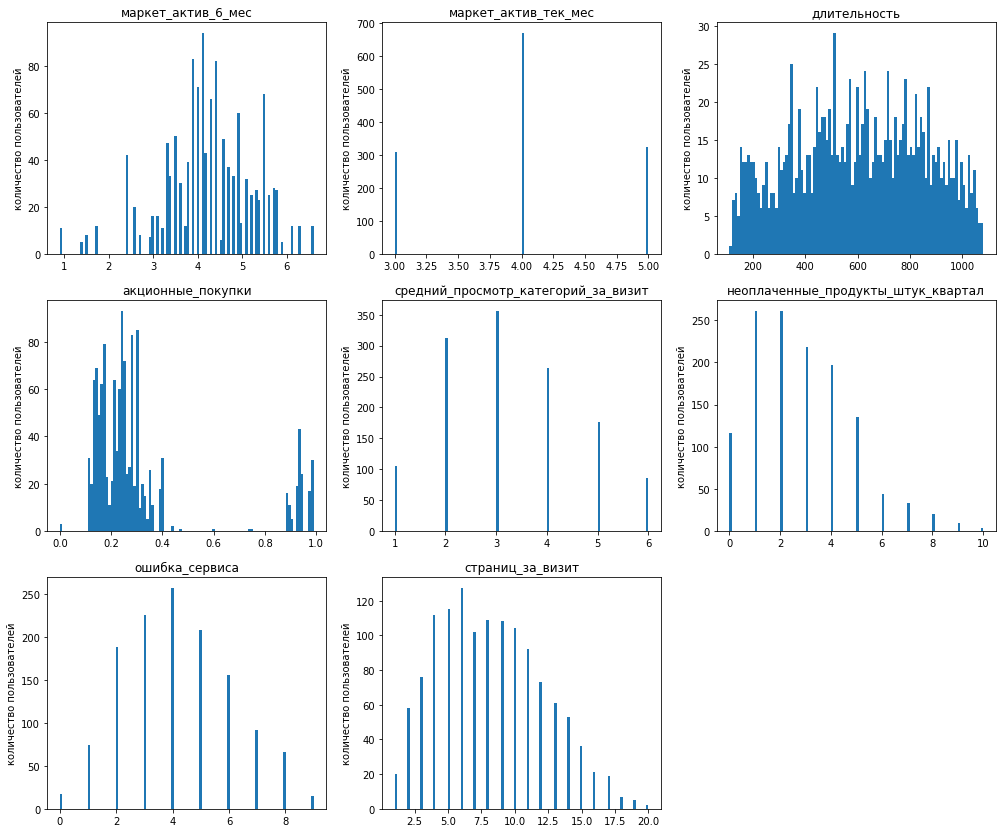

In [35]:
fig = plt.figure(figsize = (17, 40))
total_axes = len(market_file[num_col_names].columns) 

subplt = 1 

for x in market_file[num_col_names].columns:
    ax = fig.add_subplot(total_axes, 3, subplt) 
    market_file[x].plot(kind = 'hist', bins = 100) 
    subplt+=1
    plt.title(x)
    plt.ylabel('количество пользователей')
plt.show()

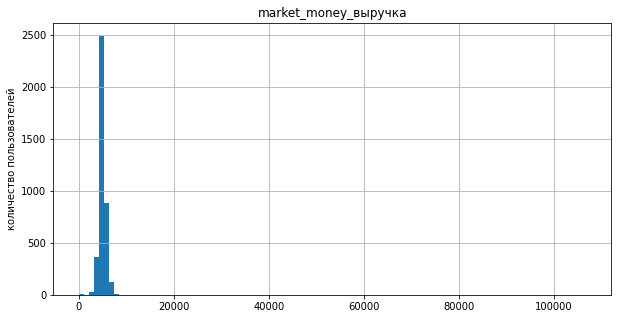

In [36]:
market_money['выручка'].hist(bins = 100, figsize = (10,5))
plt.title('market_money_выручка')
plt.ylabel('количество пользователей')
plt.show()

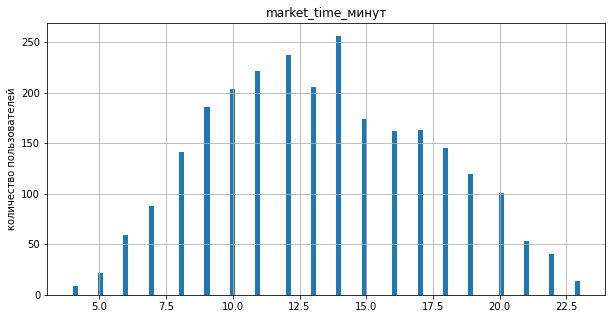

In [37]:
market_time['минут'].hist(bins = 100, figsize = (10,5))
plt.title('market_time_минут')
plt.ylabel('количество пользователей')
plt.show()

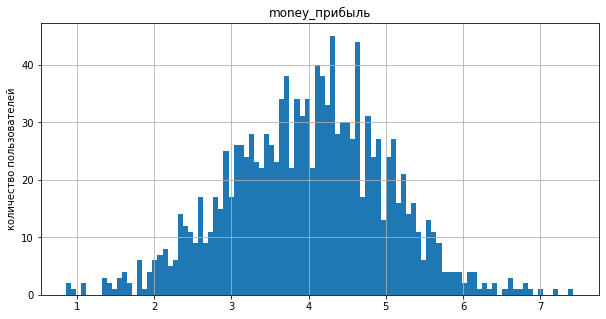

In [38]:
money['прибыль'].hist(bins = 100, figsize = (10,5))
plt.title('money_прибыль')
plt.ylabel('количество пользователей')
plt.show()

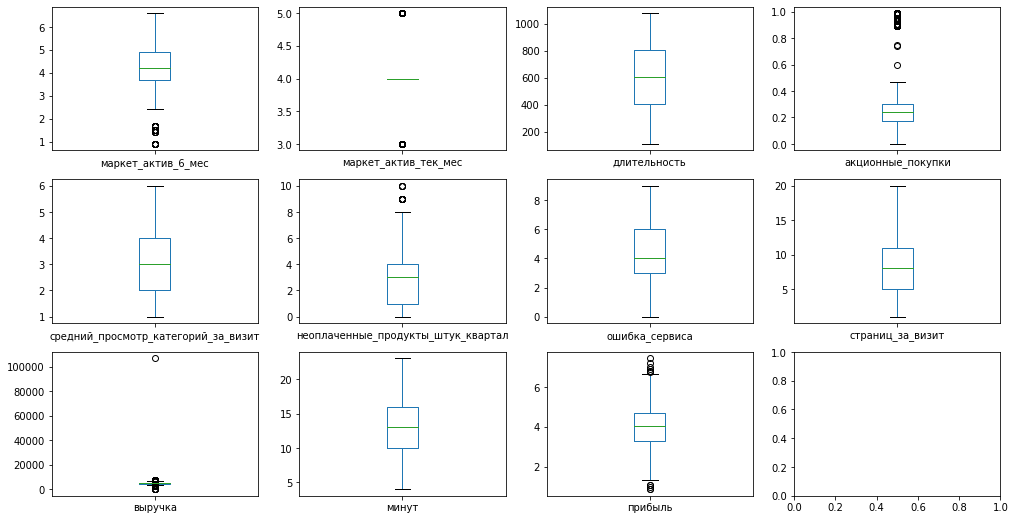

In [39]:
fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize = (17, 9))
market_file['маркет_актив_6_мес'].plot(kind = 'box', ax = axes[0,0])
market_file['маркет_актив_тек_мес'].plot(kind = 'box', ax = axes[0,1])
market_file['длительность'].plot(kind = 'box', ax = axes[0,2])
market_file['акционные_покупки'].plot(kind = 'box', ax = axes[0,3])
market_file['средний_просмотр_категорий_за_визит'].plot(kind = 'box', ax = axes[1,0])
market_file['неоплаченные_продукты_штук_квартал'].plot(kind = 'box', ax = axes[1,1])
market_file['ошибка_сервиса'].plot(kind = 'box', ax = axes[1,2])
market_file['страниц_за_визит'].plot(kind = 'box', ax = axes[1,3])
market_money['выручка'].plot(kind = 'box', ax = axes[2,0])
market_time['минут'].plot(kind = 'box', ax = axes[2,1])
money['прибыль'].plot(kind = 'box', ax = axes[2,2])
plt.show()

In [40]:
display(market_file[num_col_names].describe())

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


по итогам анализа количественных признаков выявлено следующее:
- наличие выбросов у признака "выручка", "прибыль", "акционные покупки", "маркет актив 6 мес", "неоплаченные продукты".
- распределение "акционные покупки" имеет несколько экстремумов (мультимодальное)
- распределение "минут" и "прибыль" напоминает нормальное
- распределение "неоплаченные продукты" и "страниц за визит" скошено влево

Количественные признаки являются слишком разношерстными (диапазон данных сильно различается). Целесообразно перед обучением модели стандартизировать данные.

Кроме того, необходимо удалить выбросы по "выручке"

#### статистический анализ категориальных признаков

In [41]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 1300 entries, 0 to 1299

Data columns (total 13 columns):

 #   Column                               Non-Null Count  Dtype  

---  ------                               --------------  -----  

 0   идентификатор                        1300 non-null   int64  

 1   покупательская_активность            1300 non-null   object 

 2   тип_сервиса                          1300 non-null   object 

 3   разрешить_сообщать                   1300 non-null   object 

 4   маркет_актив_6_мес                   1300 non-null   float64

 5   маркет_актив_тек_мес                 1300 non-null   int64  

 6   длительность                         1300 non-null   int64  

 7   акционные_покупки                    1300 non-null   float64

 8   популярная_категория                 1300 non-null   object 

 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  

 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  

 11  ошибка_сервиса

In [42]:
cat_col_names = ['покупательская_активность',
                'тип_сервиса',
                'разрешить_сообщать',
                'популярная_категория',
                ]

In [43]:
market_file[cat_col_names].nunique()

покупательская_активность    2
тип_сервиса                  2
разрешить_сообщать           2
популярная_категория         6
dtype: int64

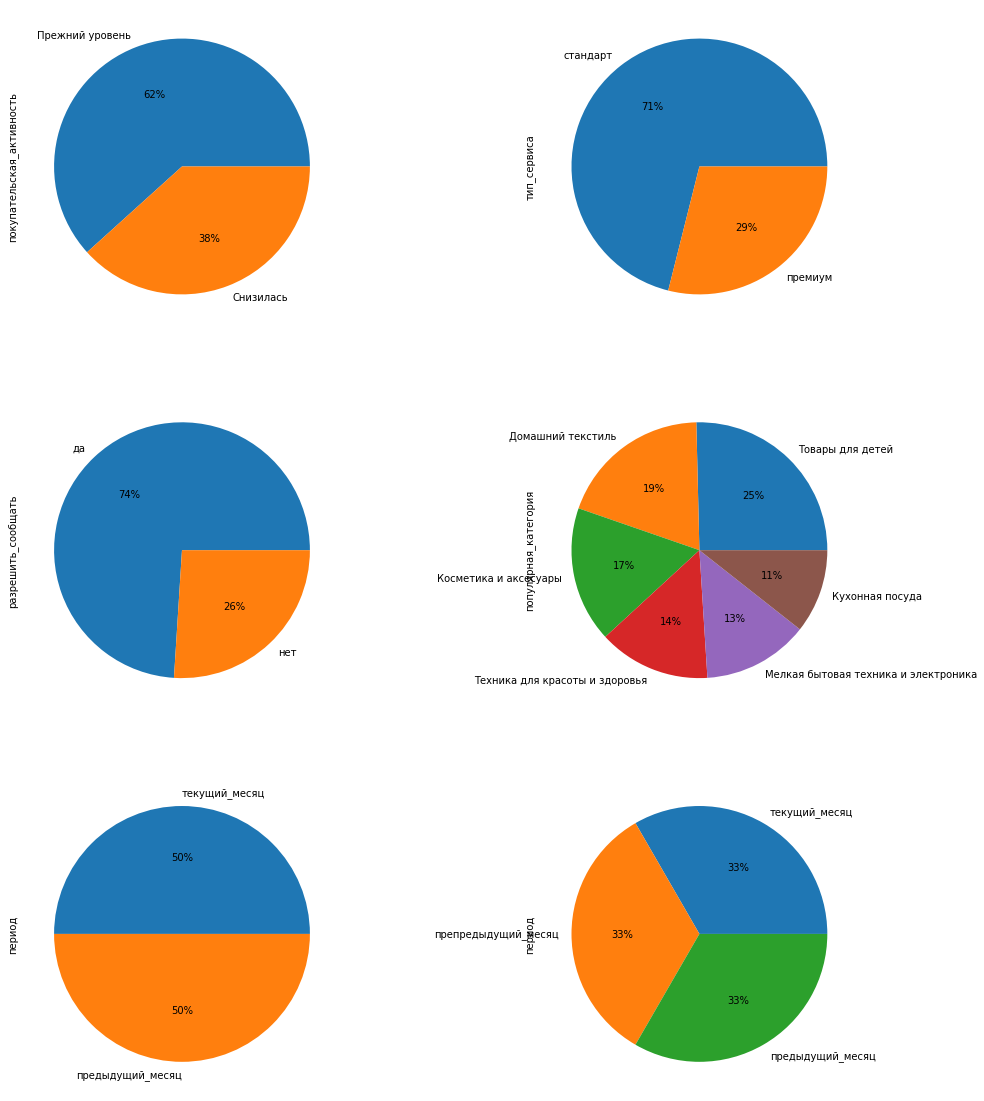

In [44]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (17, 20))
market_file['покупательская_активность'].value_counts().plot(kind = 'pie', ax = axes[0,0], autopct='%1.0f%%')
market_file['тип_сервиса'].value_counts().plot(kind = 'pie', ax = axes[0,1], autopct='%1.0f%%')
market_file['разрешить_сообщать'].value_counts().plot(kind = 'pie', ax = axes[1,0], autopct='%1.0f%%')
market_file['популярная_категория'].value_counts().plot(kind = 'pie', ax = axes[1,1], autopct='%1.0f%%')
market_time['период'].value_counts().plot(kind = 'pie', ax = axes[2,0], autopct='%1.0f%%')
market_money['период'].value_counts().plot(kind = 'pie', ax = axes[2,1], autopct='%1.0f%%')
plt.show()

по итогам анализа категориальных признаков выявлено следующее:
- данные покупательской активности пользователей содержит достаточную информацию о пользователях, чья активность снизилась (38% наблюдений)
- 30% пользователей пользуются премиальным сервисом
- 25% пользователей запрещают присылать предложения о товарах
- покупательских категорий представлено 6. все имеют примерно одинаковый вес. немного выделяется категория "товаров для детей", которая охватывает 25% наблюдений
- судя по диаграммам "период" по каждому пользователю имеется информация по каждому периоду его активности на сайте.

В целях дальнейшего обучения модели целесообразно произвести кодировку категориальных признаков

#### удаление выбросов

In [45]:
market_money.describe()

,идентификатор,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


In [46]:
market_money = market_money[(market_money['выручка'] < 100000) & (market_money['выручка'] != 0)]

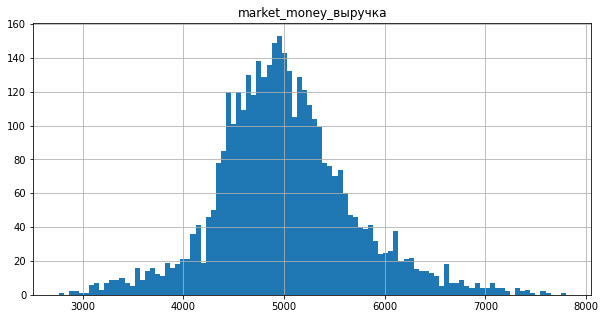

In [47]:
market_money['выручка'].hist(bins = 100, figsize = (10,5))
plt.title('market_money_выручка')
plt.show()

<AxesSubplot:>

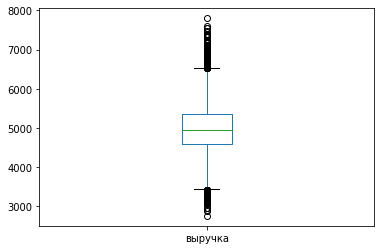

In [48]:
market_money['выручка'].plot(kind = 'box')

In [49]:
market_money.shape

(3893, 3)

выбросы целесообразно удалить по признаку выручка. именно по этому признаку наблюдается существенный разброс наблюдений. после удаления выбросов в таблице осталось 3893 наблюдений (было -  3900).

### Объединение таблиц

#### подготовка таблиц market_time и market_money к объединению

In [50]:
market_time.shape

(2600, 3)

In [51]:
market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [52]:
mt_0 = market_time[market_time['период'] == 'предыдущий_месяц']
mt_1 = market_time[market_time['период'] == 'текущий_месяц']
mt_0 = mt_0.drop('период', axis=1)
mt_0.rename(columns = {'минут':'минут_пред_месяц'},
                   inplace = True)
mt_1 = mt_1.drop('период', axis=1)
mt_1.rename(columns = {'минут':'минут_тек_месяц'},
                   inplace = True)

In [53]:
market_time_new = mt_0.merge(mt_1, how = 'inner')

In [54]:
market_time_new.head()

,идентификатор,минут_пред_месяц,минут_тек_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


In [55]:
market_time_new.shape

(1300, 3)

In [56]:
market_money.shape

(3893, 3)

In [57]:
market_money['период'].unique()

array(['текущий_месяц', 'препредыдущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [58]:
mm_0 = market_money[market_money['период'] == 'препредыдущий_месяц']
mm_1 = market_money[market_money['период'] == 'предыдущий_месяц']
mm_2 = market_money[market_money['период'] == 'текущий_месяц']

mm_0 = mm_0.drop('период', axis=1)
mm_0.rename(columns = {'выручка':'выручка_препред_месяц'},
                   inplace = True)
mm_1 = mm_1.drop('период', axis=1)
mm_1.rename(columns = {'выручка':'выручка_пред_месяц'},
                   inplace = True)
mm_2 = mm_2.drop('период', axis=1)
mm_2.rename(columns = {'выручка':'выручка_тек_месяц'},
                   inplace = True)

In [59]:
market_money_new = mm_0.merge(mm_1, how = 'inner')
market_money_new = market_money_new.merge(mm_2, how = 'inner')

In [60]:
market_money_new.head()

,идентификатор,выручка_препред_месяц,выручка_пред_месяц,выручка_тек_месяц
0,215349,4472.0,5216.0,4971.6
1,215350,4826.0,5457.5,5058.4
2,215351,4793.0,6158.0,6610.4
3,215352,4594.0,5807.5,5872.5
4,215353,5124.0,4738.5,5388.5


In [61]:
market_money_new.shape

(1296, 4)

#### создание единого датафрейма

In [62]:
market_info = market_file.merge(market_time_new, how = 'inner')
market_info = market_info.merge(market_money_new, how = 'inner')

In [63]:
market_info.shape

(1296, 18)

In [64]:
market_info.head()

,идентификатор,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_пред_месяц,минут_тек_месяц,выручка_препред_месяц,выручка_пред_месяц,выручка_тек_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,4472.0,5216.0,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,4826.0,5457.5,5058.4
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,4793.0,6158.0,6610.4
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,4594.0,5807.5,5872.5
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,5124.0,4738.5,5388.5


In [65]:
num_col= ['маркет_актив_6_мес',
                 'маркет_актив_тек_мес',
                 'длительность',
                 'акционные_покупки',
                 'средний_просмотр_категорий_за_визит',
                 'неоплаченные_продукты_штук_квартал',
                 'ошибка_сервиса',
                 'страниц_за_визит',
          'выручка_тек_месяц',
          'выручка_пред_месяц',
          'выручка_препред_месяц',
          'минут_тек_месяц',
          'минут_пред_месяц'
         ]

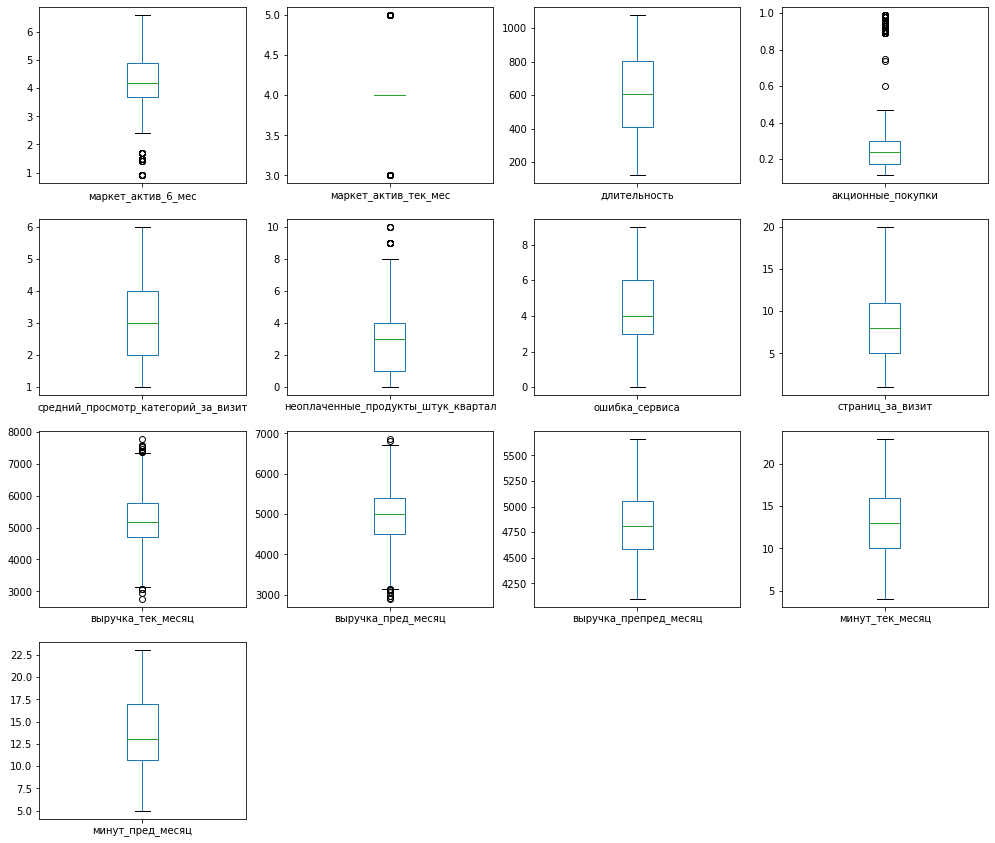

In [66]:
fig = plt.figure(figsize = (17, 50))
total_axes = len(market_info[num_col].columns) 

subplt = 1 

for x in market_info[num_col].columns:
    ax = fig.add_subplot(total_axes, 4, subplt) 
    market_info[x].plot(kind = 'box') 
    subplt+=1
    
plt.show()

по итогу объединения таблиц создана 1 таблица, в которой отдельными столбцами представлена информация о выручке и времени клиентов.

### корреляционный анализ

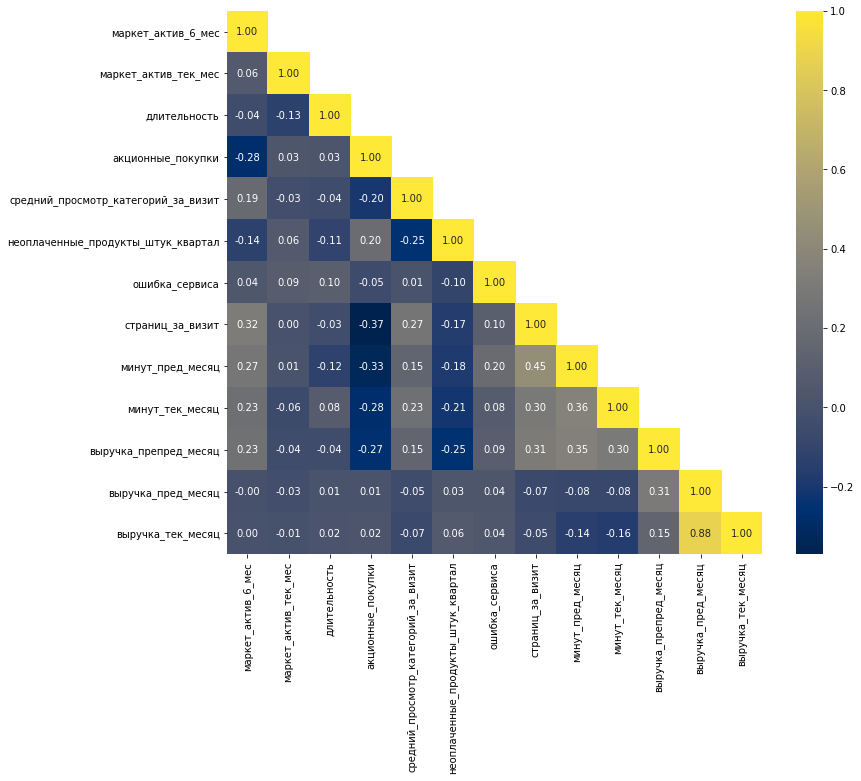

In [67]:
plt.figure(figsize=(12,10))
sns.heatmap(market_info.drop(['идентификатор'], axis=1).corr(method = 'spearman'),
            annot=True,
            cmap="cividis",
            fmt='.2f',
            mask = np.triu(market_info.drop(['идентификатор'], axis=1).corr(method = 'spearman'), k=1));  

In [68]:
interval_cols = ['маркет_актив_6_мес',
               'маркет_актив_тек_мес',
               'длительность',
               'акционные_покупки',
               'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал',
               'ошибка_сервиса',
               'страниц_за_визит',
               'минут_пред_месяц', 
               'минут_тек_месяц', 
               'выручка_препред_месяц', 
               'выручка_пред_месяц', 
               'выручка_тек_месяц']

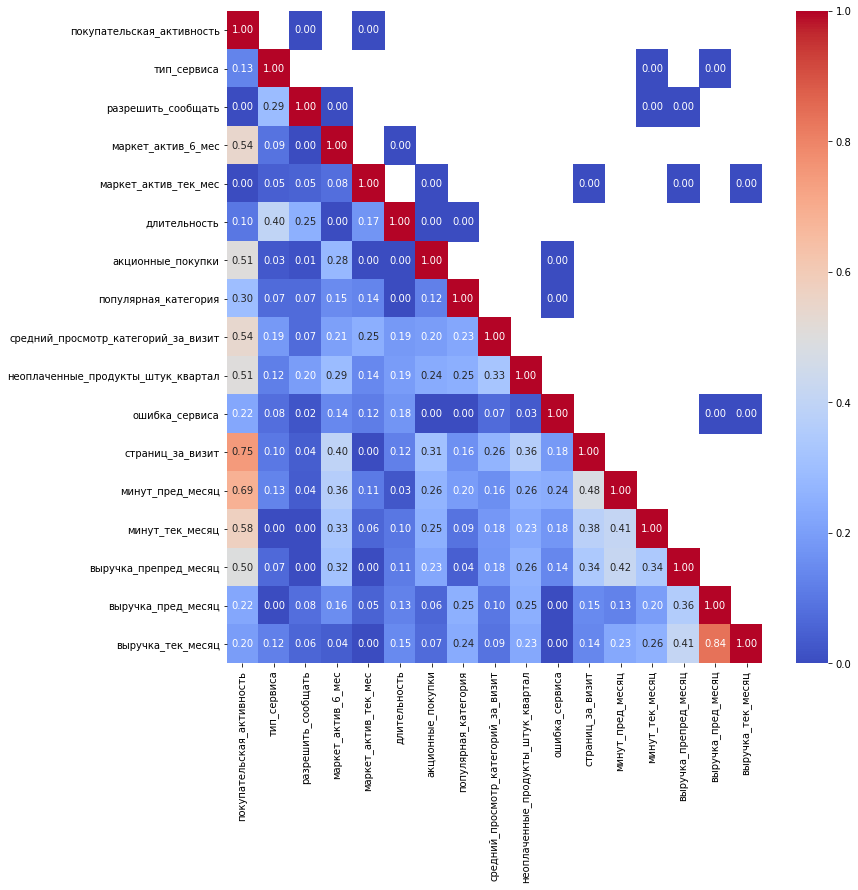

In [69]:
plt.figure(figsize=(12,12))
sns.heatmap(market_info.drop(['идентификатор'], axis=1).phik_matrix(interval_cols=interval_cols),
            annot=True,
            cmap="coolwarm",
            fmt='.2f',
            mask = np.triu(market_info.drop(['идентификатор'], axis=1).phik_matrix(interval_cols=interval_cols), k=1));

т.к. далеко не все признаки распределены нормально, логично применять корреляцию спирмана.

высоких значений корреляции между признаками не наблюдается, за исключением выручки за текущий и предыдущий месяцы.

мультиколлинеарности (значение корреляции выше 0.95) не наблюдается

### обучение модели

#### подготовка к обучению

In [70]:
market_info.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 1296 entries, 0 to 1295

Data columns (total 18 columns):

 #   Column                               Non-Null Count  Dtype  

---  ------                               --------------  -----  

 0   идентификатор                        1296 non-null   int64  

 1   покупательская_активность            1296 non-null   object 

 2   тип_сервиса                          1296 non-null   object 

 3   разрешить_сообщать                   1296 non-null   object 

 4   маркет_актив_6_мес                   1296 non-null   float64

 5   маркет_актив_тек_мес                 1296 non-null   int64  

 6   длительность                         1296 non-null   int64  

 7   акционные_покупки                    1296 non-null   float64

 8   популярная_категория                 1296 non-null   object 

 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  

 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  

 11  ошибка_сервиса

In [71]:
market_info['покупательская_активность'] = np.where(market_info['покупательская_активность'] == 'Прежний уровень', 
                                                   0,
                                                   1)

In [72]:
market_info['покупательская_активность'].unique()

array([1, 0])

In [73]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [74]:
X=market_info.drop(['покупательская_активность','идентификатор'], axis=1)
y=market_info['покупательская_активность']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [76]:
X_train.shape, X_test.shape

((972, 16), (324, 16))

целевой признак переведен в количественное выражение (0 - прежний уровень, 1 - снижение активности)

таблица нарезана на тренировочную часть 75% и тестовую 25%

#### пайплайн для нелинейных моделей

In [77]:
ohe_columns = ['тип_сервиса', 'разрешить_сообщать','популярная_категория']
num_columns = ['маркет_актив_6_мес',
               'маркет_актив_тек_мес',
               'длительность',
               'акционные_покупки',
               'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал',
               'ошибка_сервиса',
               'страниц_за_визит',
               'минут_пред_месяц', 
               'минут_тек_месяц', 
               'выручка_препред_месяц', 
               'выручка_пред_месяц', 
               'выручка_тек_месяц']

In [78]:
data_preprocessor = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first', sparse=False), ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [79]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'models__min_samples_split': range(2, 6),
        'models__min_samples_leaf': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel='sigmoid',
            probability = True
        )],
        'models__degree':range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [80]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_iter = 15
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:



 Pipeline(steps=[('preprocessor',

                 ColumnTransformer(remainder='passthrough',

                                   transformers=[('ohe',

                                                  OneHotEncoder(drop='first',

                                                                sparse=False),

                                                  ['тип_сервиса',

                                                   'разрешить_сообщать',

                                                   'популярная_категория']),

                                                 ('num', StandardScaler(),

                                                  ['маркет_актив_6_мес',

                                                   'маркет_актив_тек_мес',

                                                   'длительность',

                                                   'акционные_покупки',

                                                   'средний_просмотр

In [81]:
pd.DataFrame(randomized_search.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__n_neighbors,param_models,param_models__degree,param_models__max_features,param_models__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,0.065345,0.000969,0.007271,0.000163,StandardScaler(),NaN,"SVC(kernel='poly', probability=True, random_st...",3,NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.898928,0.904778,0.885811,0.918243,0.870721,0.895696,0.016265,1
5,0.063759,0.001067,0.007223,0.000179,MinMaxScaler(),NaN,"SVC(kernel='poly', probability=True, random_st...",2,NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.886755,0.900111,0.889752,0.914865,0.863176,0.890932,0.017008,2
14,0.007493,0.000332,0.006206,0.000154,StandardScaler(),4,KNeighborsClassifier(),NaN,NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.898537,0.882611,0.883559,0.889358,0.869144,0.884642,0.009600,3
1,0.087951,0.011886,0.007328,0.000177,MinMaxScaler(),NaN,"SVC(kernel='poly', probability=True, random_st...",3,NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.870449,0.880667,0.877703,0.909234,0.864414,0.880493,0.015448,4
3,0.106574,0.006387,0.007316,0.000161,MinMaxScaler(),NaN,"SVC(kernel='poly', probability=True, random_st...",4,NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.861738,0.880889,0.853378,0.890766,0.865090,0.870372,0.013548,5
0,0.054142,0.068681,0.021982,0.030399,StandardScaler(),2,KNeighborsClassifier(),NaN,NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.883460,0.849444,0.865484,0.865709,0.854279,0.863675,0.011744,6
2,0.005640,0.000558,0.003450,0.000173,passthrough,NaN,DecisionTreeClassifier(random_state=42),NaN,4,4,"{'preprocessor__num': 'passthrough', 'models__...",0.818349,0.829278,0.827140,0.831081,0.793694,0.819908,0.013817,7
4,0.008566,0.000350,0.004879,0.000162,StandardScaler(),NaN,DecisionTreeClassifier(random_state=42),NaN,4,4,"{'preprocessor__num': StandardScaler(), 'model...",0.818349,0.829278,0.827140,0.831081,0.793694,0.819908,0.013817,7
9,0.007719,0.000163,0.004684,0.000075,MinMaxScaler(),NaN,DecisionTreeClassifier(random_state=42),NaN,4,4,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.818349,0.829278,0.827140,0.831081,0.793694,0.819908,0.013817,7
7,0.007872,0.000639,0.004743,0.000136,MinMaxScaler(),NaN,DecisionTreeClassifier(random_state=42),NaN,2,4,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.724313,0.812000,0.807038,0.826633,0.804617,0.794920,0.036121,10


В качестве метрики целесообразно выбрать ROC-AUC, т.к. она позволяет оценить качество работы модели вне зависимости от выбранного порога вероятности. Кроме того, метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другим. В нашем случае соотношение - 62% / 38%.

для кажой модели перебираются различные кодировщики и гиперпараметры. В связи с тем, что итераций не мало, для перебора гиперпараметров использован RandomizedSearchCV.

По итогу перебора лучшая модель - SVC с ядром poly.

#### пайплайн для логистической регрессии

In [82]:
ohe_columns_lr = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

In [83]:
data_preprocessor_lr = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first', sparse=False), ohe_columns_lr),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough')

pipe_final_lr = Pipeline([
    ('preprocessor', data_preprocessor_lr),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [84]:
param_grid_lr = [{
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
}]

In [85]:
randomized_search_lr = RandomizedSearchCV(
    pipe_final_lr, 
    param_grid_lr, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter = 15
)
randomized_search_lr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_lr.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_lr.best_score_)

Лучшая модель и её параметры:



 Pipeline(steps=[('preprocessor',

                 ColumnTransformer(remainder='passthrough',

                                   transformers=[('ohe',

                                                  OneHotEncoder(drop='first',

                                                                sparse=False),

                                                  ['тип_сервиса',

                                                   'разрешить_сообщать',

                                                   'популярная_категория']),

                                                 ('num', MinMaxScaler(),

                                                  ['маркет_актив_6_мес',

                                                   'маркет_актив_тек_мес',

                                                   'длительность',

                                                   'акционные_покупки',

                                                   'средний_просмотр_к

In [86]:
pd.DataFrame(randomized_search_lr.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__C,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.019551,0.003598,0.006159,0.001354,MinMaxScaler(),1,"LogisticRegression(C=1, penalty='l1', random_s...","{'preprocessor__num': MinMaxScaler(), 'models_...",0.895801,0.912667,0.890203,0.920158,0.872973,0.898360,0.016718,1
11,0.023135,0.004888,0.005841,0.000666,MinMaxScaler(),2,"LogisticRegression(C=1, penalty='l1', random_s...","{'preprocessor__num': MinMaxScaler(), 'models_...",0.896471,0.907778,0.888176,0.919707,0.870833,0.896593,0.016696,2
6,0.021320,0.000977,0.005093,0.000289,MinMaxScaler(),6,"LogisticRegression(C=1, penalty='l1', random_s...","{'preprocessor__num': MinMaxScaler(), 'models_...",0.897923,0.905556,0.887725,0.921171,0.869932,0.896461,0.017179,3
4,0.008959,0.000186,0.004700,0.000059,StandardScaler(),1,"LogisticRegression(C=1, penalty='l1', random_s...","{'preprocessor__num': StandardScaler(), 'model...",0.897476,0.905222,0.887275,0.921734,0.870383,0.896418,0.017210,4
1,0.021002,0.000654,0.004950,0.000108,MinMaxScaler(),5,"LogisticRegression(C=1, penalty='l1', random_s...","{'preprocessor__num': MinMaxScaler(), 'models_...",0.897029,0.905667,0.888063,0.920833,0.870045,0.896327,0.017014,5
9,0.009468,0.000307,0.004749,0.000055,StandardScaler(),9,"LogisticRegression(C=1, penalty='l1', random_s...","{'preprocessor__num': StandardScaler(), 'model...",0.898704,0.904556,0.885698,0.923423,0.868694,0.896215,0.018353,6
8,0.009490,0.000223,0.004730,0.000129,StandardScaler(),5,"LogisticRegression(C=1, penalty='l1', random_s...","{'preprocessor__num': StandardScaler(), 'model...",0.898481,0.904222,0.885923,0.923198,0.869144,0.896194,0.018089,7
3,0.009738,0.000213,0.004897,0.000296,StandardScaler(),8,"LogisticRegression(C=1, penalty='l1', random_s...","{'preprocessor__num': StandardScaler(), 'model...",0.898704,0.904556,0.885698,0.923423,0.868581,0.896193,0.018386,8
14,0.009583,0.000337,0.005176,0.000272,StandardScaler(),6,"LogisticRegression(C=1, penalty='l1', random_s...","{'preprocessor__num': StandardScaler(), 'model...",0.898593,0.904556,0.885811,0.923086,0.868806,0.896170,0.018203,9
2,0.010170,0.000616,0.005213,0.000212,StandardScaler(),4,"LogisticRegression(C=1, penalty='l1', random_s...","{'preprocessor__num': StandardScaler(), 'model...",0.897699,0.904556,0.885923,0.923086,0.869257,0.896104,0.018036,10


для логистической регрессии сделан отдельный пайплайн, не предполагающий кодирование с помощью OrdinalEncoder, т.к. есть риск, что линейная модель может найти зависимость между порядковыми номерами категорий, полученных с помощью этого кодировщика.

для модели перебираются различные кодировщики и гиперпараметр C. Для перебора гиперпараметров также использован RandomizedSearchCV.

По итогу перебора лучшая модель - LR с С=1 и кодировщиком MinMaxScaler.

In [87]:
x_train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
x_test = pipe_final.named_steps['preprocessor'].transform(X_test)
randomized_search.best_estimator_.named_steps['models'].fit(x_train, y_train)
y_test_pred = randomized_search.best_estimator_.named_steps['models'].predict_proba(x_test)[:,1]
print(f'Метрика ROC-AUC модели SVC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC модели SVC на тестовой выборке: 0.9143307850988958


In [88]:
x_train_lr = pipe_final_lr.named_steps['preprocessor'].fit_transform(X_train)
x_test_lr = pipe_final_lr.named_steps['preprocessor'].transform(X_test)
randomized_search_lr.best_estimator_.named_steps['models'].fit(x_train_lr, y_train)
y_test_pred_lr = randomized_search_lr.best_estimator_.named_steps['models'].predict_proba(x_test_lr)[:,1]
print(f'Метрика ROC-AUC модели LR на тестовой выборке: {roc_auc_score(y_test, y_test_pred_lr)}')

Метрика ROC-AUC модели LR на тестовой выборке: 0.9182138090037617


модель лостической регрессии является лучшей

### анализ важности признаков

In [89]:
x_train = pipe_final_lr.named_steps['preprocessor'].fit_transform(X_train)

In [90]:
randomized_search_lr.best_estimator_.named_steps['models'].fit(x_train, y_train)

LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')

In [91]:
explainer = shap.LinearExplainer(randomized_search_lr.best_estimator_.named_steps['models'], x_train)

In [92]:
feature_names = pipe_final_lr.named_steps['preprocessor'].get_feature_names_out()
x_test = pd.DataFrame(pipe_final_lr.named_steps['preprocessor'].transform(X_test),
                      columns = feature_names)

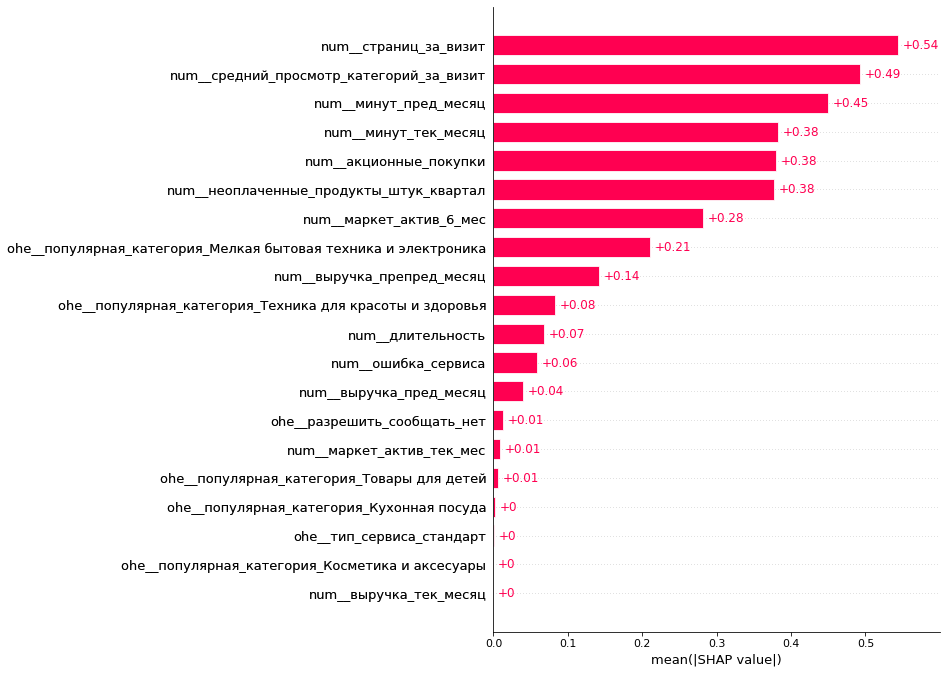

In [93]:
shap_values = explainer(x_test)
shap.plots.bar(shap_values, max_display=20)

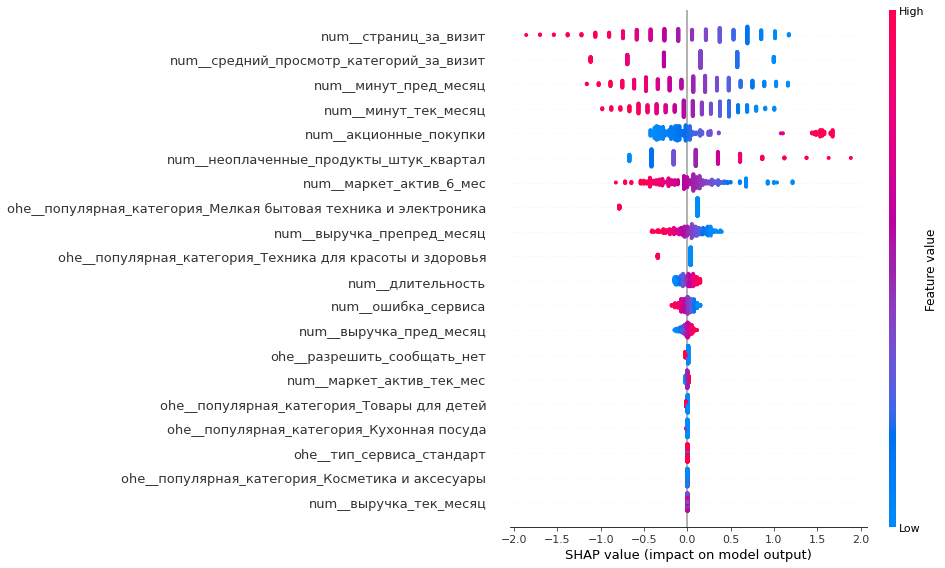

In [94]:
shap.plots.beeswarm(shap_values, max_display=20)

<AxesSubplot:ylabel='Feature'>

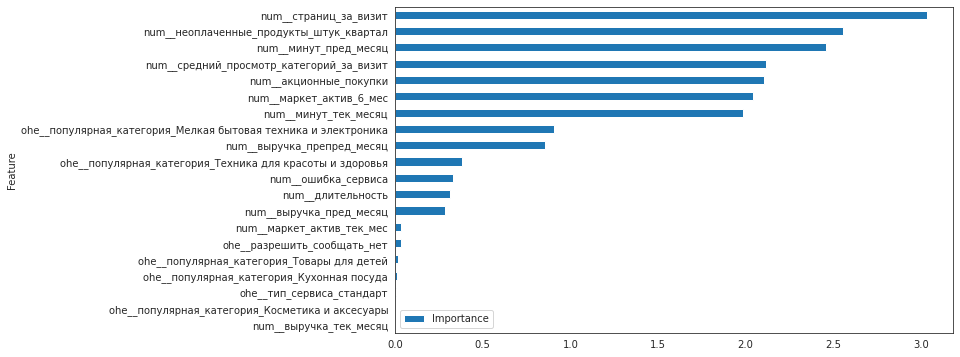

In [95]:
coefficients = randomized_search_lr.best_estimator_.named_steps['models'].coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

наиболее высокие коэффициенты логистической регрессии у признаков: 
1. страниц за визит
2. неоплаченные продукты штук квартал
3. минут предыдущий месяц

анализ SHAP-значений показал, что наиболее влиятельные на результаты признаки: 

1. страниц за визит
2. средний просмотр категорий за визит
3. минут предыдущий месяц

наименее важные признаки - выручка тек месяца и популярная категория (Косметика и аксесуары), тип_сервиса

**анализ важности признаков позволяет сделать следующие выводы:**

С точки зрения модели наиболее важными признаками для прогноза клиентской активности являются:
- количество просмотренных пользователем категорий в течение последнего месяца
- количество просмотренных пользователем страниц за последние 3 месяца 
- количество времени, проведенного пользователем на сайте за предыдущий месяц
- количество неоплаченных продуктов в штуках за квартал
- маркетинговая активность за последние 6 месяцев

при принятии бизнес-решений целесообразно учитывать данные выводы

### сегментация покупателей

#### выбор и выделение сегмента в отдельный датафрейм

Для дополнительного анализа выбрана группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

In [96]:
x_test = pipe_final_lr.named_steps['preprocessor'].transform(X_test)

In [97]:
prob = randomized_search_lr.best_estimator_.named_steps['models'].predict_proba(x_test)[:, 1]

In [98]:
X_test['вероятность'] = prob

In [99]:
X_test.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_пред_месяц,минут_тек_месяц,выручка_препред_месяц,выручка_пред_месяц,выручка_тек_месяц,вероятность
809,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,16,17,4912.0,3973.0,3289.2,0.013655
302,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,11,9,4656.0,3548.0,4170.7,0.984822
955,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,20,11,4565.0,5444.0,6335.8,0.113700
149,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,9,9,4993.0,6604.0,6758.7,0.756637
582,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,15,18,4451.0,5090.0,5773.8,0.521929


In [100]:
X_test.shape

(324, 17)

In [101]:
profit = X_test.merge(money, how='inner', left_index=True, right_index=True)
profit = profit.merge(y_test, how='inner', left_index=True, right_index=True)

In [102]:
profit.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_пред_месяц,минут_тек_месяц,выручка_препред_месяц,выручка_пред_месяц,выручка_тек_месяц,вероятность,идентификатор,прибыль,покупательская_активность
809,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,16,17,4912.0,3973.0,3289.2,0.013655,216157,3.95,0
302,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,11,9,4656.0,3548.0,4170.7,0.984822,215650,2.54,1
955,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,20,11,4565.0,5444.0,6335.8,0.113700,216303,4.69,0
149,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,9,9,4993.0,6604.0,6758.7,0.756637,215497,4.17,1
582,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,15,18,4451.0,5090.0,5773.8,0.521929,215930,2.77,1


Text(0, 0.5, 'прибыль')

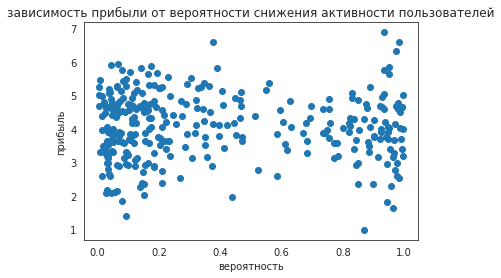

In [103]:
plt.scatter(profit['вероятность'], profit['прибыль'])
plt.title('зависимость прибыли от вероятности снижения активности пользователей')
plt.xlabel('вероятность')
plt.ylabel('прибыль')

на диаграмме рассеяния видно, что выбранный сегмент расположен в правом верхнем углу и ей соответствуют следующие параметры: вероятность снижения > 0.7, прибыль > 3.

In [104]:
segment = profit[(profit['вероятность'] > 0.7) & (profit['прибыль']>3)]

In [105]:
rest = profit.drop(index = segment.index)

In [106]:
segment.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_пред_месяц,минут_тек_месяц,выручка_препред_месяц,выручка_пред_месяц,выручка_тек_месяц,вероятность,идентификатор,прибыль,покупательская_активность
149,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,9,9,4993.0,6604.0,6758.7,0.756637,215497,4.17,1
492,премиум,да,4.3,4,1041,0.99,Кухонная посуда,4,1,6,6,9,14,4880.0,5339.0,5866.8,0.782974,215840,3.20,1
132,премиум,нет,2.9,5,448,0.23,Товары для детей,4,2,6,3,5,7,4267.0,5059.0,5018.7,0.888615,215480,4.04,1
319,премиум,да,4.0,4,820,0.22,Косметика и аксесуары,1,4,8,6,7,8,4670.0,5379.5,6034.7,0.921796,215667,3.70,1
11,премиум,да,4.2,4,438,0.74,Домашний текстиль,3,4,6,4,13,13,4765.0,4314.0,4447.9,0.830525,215359,5.08,1


In [107]:
rest.shape, segment.shape, profit.shape

((248, 20), (76, 20), (324, 20))

#### сравнительный анализ сегмента с "остальными"

In [108]:
cols_for_graph= ['средний_просмотр_категорий_за_визит',
                 'страниц_за_визит',
                 'минут_тек_месяц',
                 'минут_пред_месяц',
                 'акционные_покупки',
                 'неоплаченные_продукты_штук_квартал',
                 'длительность',
                 'ошибка_сервиса'
                 ]

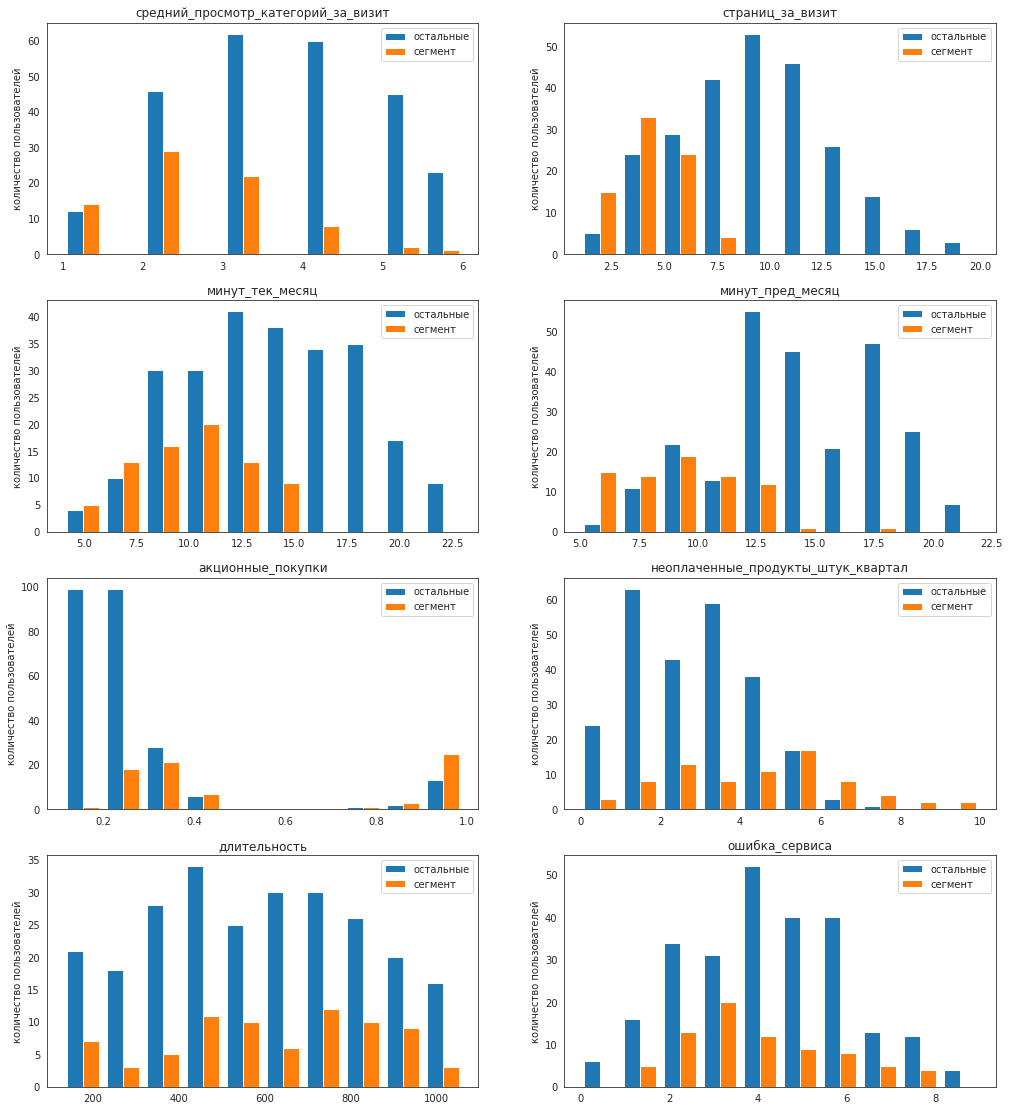

In [109]:
fig = plt.figure(figsize = (17, 40))
total_axes = len(rest[cols_for_graph].columns) 

subplt = 1 

for x in rest[cols_for_graph].columns:
    ax = fig.add_subplot(total_axes, 2, subplt) 
    plt.hist([rest[x], segment[x]]) 
    subplt+=1
    plt.title(x)
    plt.ylabel('количество пользователей')
    plt.legend(['остальные', 'сегмент'])
plt.show()

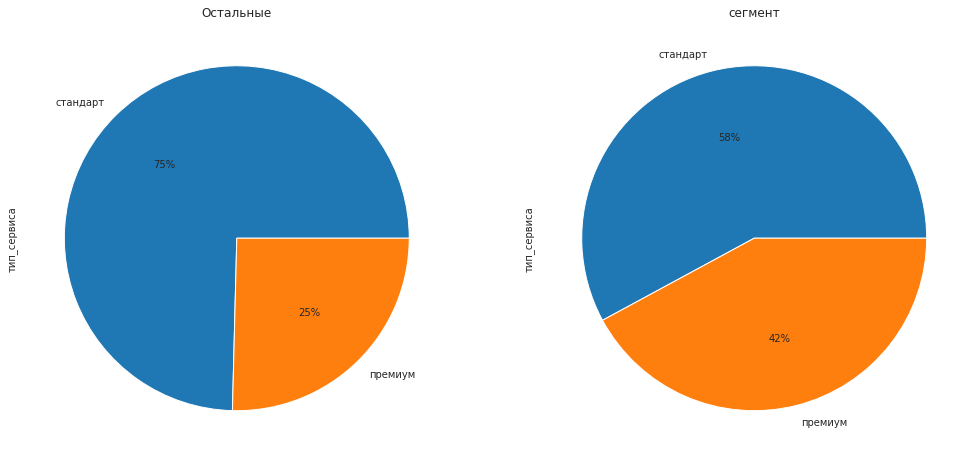

In [110]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 20))
rest['тип_сервиса'].value_counts().plot(kind = 'pie', ax = axes[0], autopct='%1.0f%%')
axes[0].set_title('Остальные')
segment['тип_сервиса'].value_counts().plot(kind = 'pie', ax = axes[1], autopct='%1.0f%%')
axes[1].set_title('сегмент');

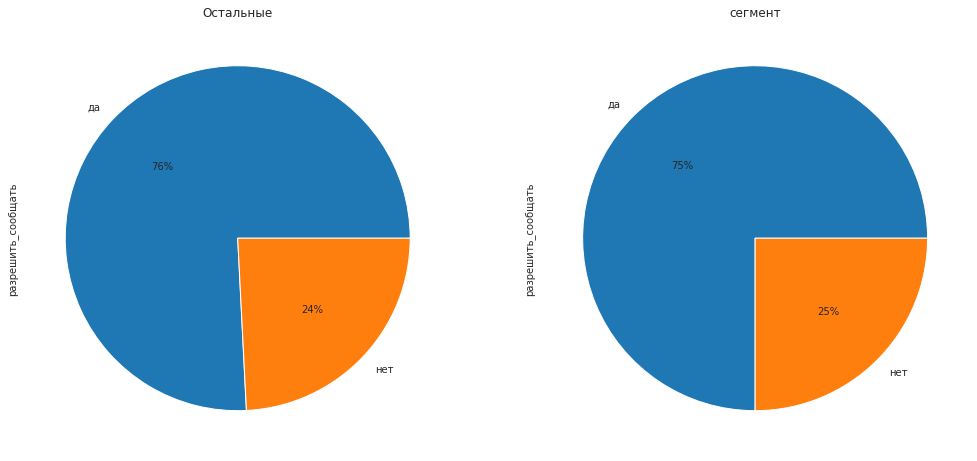

In [111]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 20))
rest['разрешить_сообщать'].value_counts().plot(kind = 'pie', ax = axes[0], autopct='%1.0f%%')
axes[0].set_title('Остальные')
segment['разрешить_сообщать'].value_counts().plot(kind = 'pie', ax = axes[1], autopct='%1.0f%%')
axes[1].set_title('сегмент');

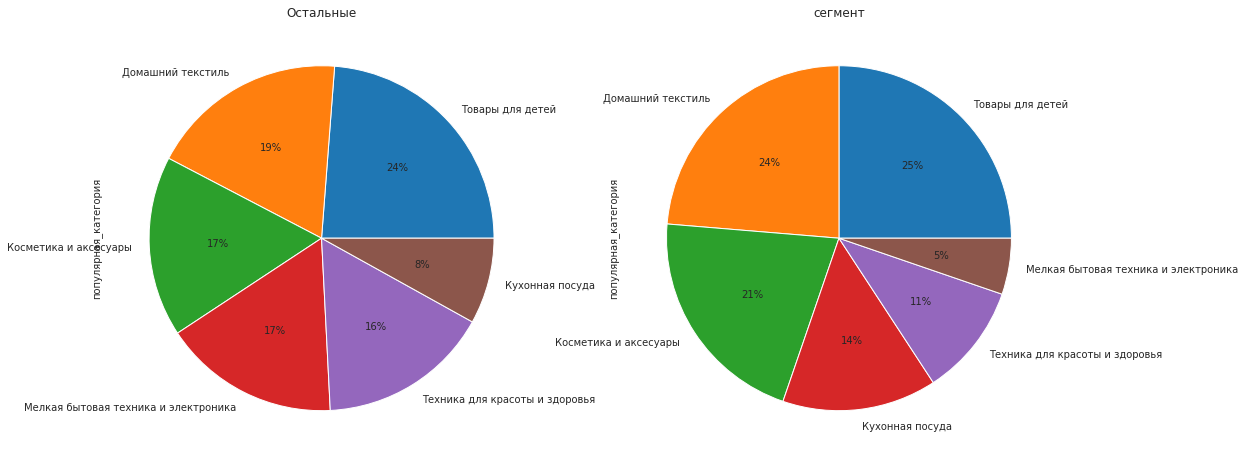

In [112]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 20))
rest['популярная_категория'].value_counts().plot(kind = 'pie', ax = axes[0], autopct='%1.0f%%')
axes[0].set_title('Остальные')
segment['популярная_категория'].value_counts().plot(kind = 'pie', ax = axes[1], autopct='%1.0f%%')
axes[1].set_title('сегмент');

In [113]:
cols_for_analysis = ['тип_сервиса', 
               'выручка_пред_месяц', 
               'выручка_тек_месяц']

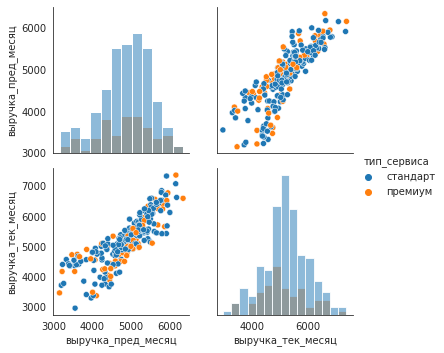

In [115]:
g = sns.PairGrid(rest[cols_for_analysis], hue='тип_сервиса')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();

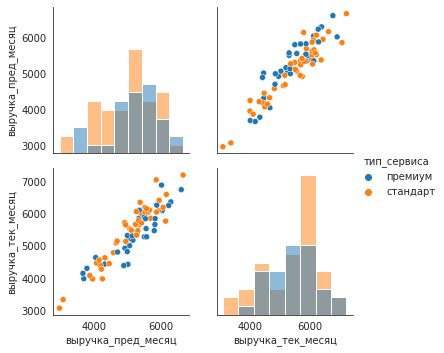

In [116]:
g = sns.PairGrid(segment[cols_for_analysis], hue='тип_сервиса')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
g.fig;

Индивидуальной особенностью выбранного сегмента является:
- более высокое количество неоплаченных продуктов в квартал
- доля акционных покупок выше,чем у остальных клиентов
- меньшее количество просматриваемых категорий за визит
- бОльшая доля клиентов с сервисом премиум

Кроме того, наблюдается высокая линейная связь между показателями выручки текущего и предыдущего периода.
Т.е. если выручка предыдущего периода снизилась по сравнению с препредыдущим, то с высокой вероятностью она снизится в текущем периоде.

#### рекомендации

компания имеет возможность влиять на признак маркет_актив_6 мес, который отвечает за среднее количество коммуникаций с клиентом за предыдущие 6 месяцев

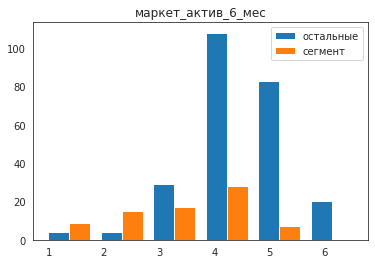

In [117]:
plt.hist([rest['маркет_актив_6_мес'], segment['маркет_актив_6_мес']], label = ['остальные', 'сегмент'], bins=6)
plt.title('маркет_актив_6_мес')
plt.legend();

На графике маркетинговой активности за предыдущие 6 месяцев видно, что на клиентов из выбранного сегмента приходилось меньше рассылок, звонков, показов рекламы и прочего, чем по остальным клиентам.

С учетом того, что с точки зрения модели данный показатель является значимым, целесообразно по данному сегменту планомерно увеличивать маркетинговую активность.

При этом увеличение маркетинговой активности должно осуществляться с учетом индивидуальных особенностей сегмента:
- количество коммуникаций целесообразно нарастить до 4-5 в месяц
- целесообразно маркетинговую активность ограничить 2-3 категориями товаров. учитывая, что с точки зрения модели тип категории не имеет большого значения, то стоит выбрать 3 наиболее популярные у сегмента категории (товары для детей, домашний текстиль, косметика и аксессуары)
- учитывая повышенное количество неоплаченных товаров в корзине у данного сегмента стоит подумать над адресным предложением клиентам по товарам, находящимся в корзине (к примеру снижение стоимости доставки)

Учитывая наличие сильной прямопропорциональной связи меджу выручкой предыдущего периода и текущим периодом, стоит в первую очередь обратить внимание на клиентов, по которым наблюдается снижение выручки в предыдущих периодах.

### общий вывод

#### описание задачи

1.	Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2.	В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3.	Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

#### исходные данные и предобработка

для моделирования предоставлены данные в 4-х таблицах:
- market_file содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- market_money содержит данные о выручке, которую получает магазин.
- market_time содержит данные о времени (в минутах), которое покупатель провёл на сайте.
- money содержит данные о среднемесячной прибыли покупателя за последние 3 месяца

в ходе предобработки:
1. в категориальных столбцах таблиц были выявлены неявные дубликаты:
- в столбце "тип сервиса" таблицы market_file были дубликаты "стандартт" и "стандарт". стандартт заменен на стандарт
- в столбце "период" таблицы market_time была ошибка в категории "предыдцщий_месяц". ошибка исправлена
2. Все наименования столбцов унифицированы: кириллица, нижний регистр, разделитель _

#### исследовательский и корреляционный анализ

1. по итогам анализа количественных признаков выявлено следующее:
- наличие выбросов у признака "выручка", "прибыль", "акционные покупки", "маркет актив 6 мес", "неоплаченные продукты".
- распределение "акционные покупки" имеет несколько экстремумов (мультимодальное)
- распределение "минут" и "прибыль" напоминает нормальное
- распределение "неоплаченные продукты" и "страниц за визит" скошено влево

Количественные признаки являются слишком разношерстными (диапазон данных сильно различается). Целесообразно перед обучением модели стандартизировать данные.

выбросы по признаку "выручка" в таблице market_money были удалены.

2. по итогам анализа категориальных признаков выявлено следующее:
- данные покупательской активности пользователей содержит достаточную информацию о пользователях, чья активность снизилась (38% наблюдений)
- 30% пользователей пользуются премиальным сервисом
- 25% пользователей запрещают присылать предложения о товарах
- покупательских категорий представлено 6. все имеют примерно одинаковый вес. немного выделяется категория "товаров для детей", которая охватывает 25% наблюдений
- судя по диаграммам "период" по каждому пользователю имеется информация по каждому периоду его активности на сайте.

В целях дальнейшего обучения модели целесообразно произвести кодировку категориальных признаков.

#### корреляционный анализ

Не все признаки распределены нормально, поэтому в целях анализа корреляций применена корреляция Спирмана.

Высоких значений корреляции между признаками не наблюдается, за исключением выручки за текущий и предыдущий месяцы.

мультиколлинеарности (значение корреляции выше 0.95) не наблюдается.

#### объединение таблиц

по итогу объединения таблиц market_file, narket_money и market_time создана одна таблица market_info, в которой отдельными столбцами представлена информация о выручке и времени клиентов за разные периоды времени

#### моделирование

В качестве метрики была выбрана ROC-AUC, т.к. она позволяет оценить качество работы модели вне зависимости от выбранного порога вероятности. Кроме того, метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другим. В нашем случае соотношение - 62% / 38%.

Для кажой модели перебирались различные кодировщики и гиперпараметры. В связи с тем, что итераций достаточно много, для перебора гиперпараметров использован RandomizedSearchCV.

По итогу перебора лучшая модель - Логистическая регрессия с С=5, solver = liblinear, penalty = l1. Для кодировки количественных признаков - MinMaxScaler. 

метрика качества ROC-AUC получилась очень неплохой - 0.9087 / 0.843 (тренировочная / тестовая)

#### анализ важности признаков

проведенный анализ важности признаков привел к следующим выводам:

С точки зрения модели наиболее важными признаками для прогноза клиентской активности являются:
- количество просмотренных пользователем категорий в течение последнего месяца
- количество просмотренных пользователем страниц за последние 3 месяца 
- количество времени, проведенного пользователем на сайте за предыдущий месяц
- количество неоплаченных продуктов в штуках за квартал
- маркетинговая активность за последние 6 месяцев

при принятии бизнес-решений целесообразно учитывать данные выводы

#### сегментация покупателей и рекомендации по сегменту

для дополнительного анализа выбрана группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

Индивидуальной особенностью выбранного сегмента является:
- более высокое количество неоплаченных продуктов в квартал
- доля акционных покупок выше,чем у остальных клиентов
- меньшее количество просматриваемых категорий за визит
- бОльшая доля клиентов с сервисом премиум

Кроме того, наблюдается высокая линейная связь между показателями выручки текущего и предыдущего периода.

Т.е. если выручка предыдущего периода снизилась по сравнению с препредыдущим, то с высокой вероятностью она снизится в текущем периоде.

Компания имеет возможность влиять на признак маркет_актив_6 мес, который отвечает за среднее количество коммуникаций с клиентом за предыдущие 6 месяцев

С учетом того, что с точки зрения модели данный показатель является значимым, целесообразно по данному сегменту планомерно увеличивать маркетинговую активность.

При этом увеличение маркетинговой активности должно осуществляться с учетом индивидуальных особенностей сегмента:
- количество коммуникаций целесообразно нарастить до 4-5 в месяц
- целесообразно маркетинговую активность ограничить 2-3 категориями товаров. учитывая, что с точки зрения модели тип категории не имеет большого значения, то стоит выбрать 3 наиболее популярные у сегмента категории (товары для детей, домашний текстиль, косметика и аксессуары)
- учитывая повышенное количество неоплаченных товаров в корзине у данного сегмента стоит подумать над адресным предложением клиентам по товарам, находящимся в корзине (к примеру снижение стоимости доставки)

Учитывая наличие сильной прямопропорциональной связи меджу выручкой предыдущего периода и текущим периодом, стоит в первую очередь обратить внимание на клиентов, по которым наблюдается снижение выручки в предыдущих периодах.